# Fullback Overlapping Runs Project
For the project, you will be assuming the role of Data Analyst at an MLS club. You've been tasked with sending your supervisor a CSV containing a **timestamped** list of **Fullback Overlaps**, ranked in order of **effectiveness**, from your last match. 

**Fullback Overlap Definition**: The left or right back, runs around (towards the exterior of the pitch) a teammate in possession of the ball and ahead of them (teammate and the ball) into space.

In [1]:
#Import Libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplsoccer as mpl

In [2]:
#Import Metadata
with open('metadata.json', 'r') as json_file:
    metadata = json.load(json_file)
metadata

{'venueId': '625a6c10-c9a5-4158-8651-70a4d9158da6',
 'description': 'ORL - CHI : 2022-4-9',
 'startTime': 1649524084014,
 'year': 2022,
 'month': 4,
 'day': 9,
 'pitchLength': 109.908447265625,
 'pitchWidth': 68.68302154541016,
 'fps': 25.0,
 'periods': [{'number': 1,
   'startFrameClock': 1649524084014,
   'endFrameClock': 1649526831934,
   'startFrameIdx': 0,
   'endFrameIdx': 68698,
   'homeAttPositive': False},
  {'number': 2,
   'startFrameClock': 1649527862094,
   'endFrameClock': 1649530851934,
   'startFrameIdx': 68699,
   'endFrameIdx': 143445,
   'homeAttPositive': True}],
 'homePlayers': [{'name': 'Alexandre Pato',
   'number': 7,
   'position': 'RW',
   'ssiId': 'af40214c-a921-4b29-93b0-51a36aa16301',
   'optaId': '45215',
   'optaUuid': '8pwkzin8inlb21hdxjfu01dxx'},
  {'name': 'P. Gallese',
   'number': 1,
   'position': 'GK',
   'ssiId': 'c44c297f-e480-4db2-b8ea-b0d161e6dc65',
   'optaId': '174577',
   'optaUuid': '2q8ntruz96k9ia7np1tma4udx'},
  {'name': 'T. Akindele',
  

In [3]:
#Use Metadata to identify homePLayers & awayPlayers
hp = metadata['homePlayers']
ap = metadata['awayPlayers']
home_players = pd.DataFrame.from_dict(hp)
away_players = pd.DataFrame.from_dict(ap)
home_players.drop(columns=['ssiId','optaUuid'], inplace=True)
away_players.drop(columns=['ssiId','optaUuid'], inplace=True)

In [4]:
home_players

,name,number,position,optaId
0,Alexandre Pato,7,RW,45215
1,P. Gallese,1,GK,174577
2,T. Akindele,13,SUB,177947
3,K. Smith,24,SUB,227733
4,J. Lynn,27,SUB,425333
5,R. Schlegel,15,RCB,421184
6,B. Michel,19,SUB,451038
7,Roby Jansson,6,LCB,85601
8,Joao Moutinho,4,LB,443002
9,T. Williams,68,SUB,495767


In [5]:
away_players 

,name,number,position,optaId
0,B. Gutierrez,40,CAM,451375
1,J. Espinoza,14,LB,427869
2,S. Richey,18,SUB,172761
3,J. Duran,26,SUB,476344
4,J. Casas,37,SUB,440526
5,G. Slonina,1,GK,471798
6,Andre Reynolds,36,SUB,426473
7,W. Omsberg,20,RCB,442451
8,K. Przybylko,11,ST,107091
9,K. Burks,27,SUB,565620


In [6]:
#Import Tracking Data
tracking_df = pd.read_csv('tracking_data.csv')
tracking_df.head()

,period_id,frame_idx,game_clock,wall_clock,live,last_touch_team_id,team_id,player_id,player_number,speed,x,y,z,ball_x,ball_y,ball_z,ball_speed
0,1,0,0.0,1649524084014,False,6900,1207,41700,3,0.0,-3.73,21.60,0.0,0.41,0.01,0.17,12.9
1,1,0,0.0,1649524084014,False,6900,1207,451375,40,0.0,-5.56,11.40,0.0,0.41,0.01,0.17,12.9
2,1,0,0.0,1649524084014,False,6900,1207,442451,20,0.0,-16.99,-5.24,0.0,0.41,0.01,0.17,12.9
3,1,0,0.0,1649524084014,False,6900,1207,229903,99,0.0,-1.18,-17.13,0.0,0.41,0.01,0.17,12.9
4,1,0,0.0,1649524084014,False,6900,1207,464785,31,0.0,-12.08,-1.23,0.0,0.41,0.01,0.17,12.9


In [7]:
tracking_df.shape

(3076066, 17)

# Data Proccessing

In [8]:
#Invert Coordinates for Second Half
tracking_df.loc[tracking_df['period_id'] == 2, ['x', 'y', 'ball_x', 'ball_y']] *= -1

In [9]:
#Function to Calculate Velocity Vectors to Tracking Data
def calculate_velocity(df, smoothing=True, window=7, polyorder=1, maxspeed=12):
    # Calculate differences in position and time
    df['delta_x'] = df.groupby('player_id')['x'].diff()
    df['delta_y'] = df.groupby('player_id')['y'].diff()
    df['delta_time'] = df.groupby('player_id')['game_clock'].diff()

    # Calculate unsmoothed velocity components
    df['vx'] = df['delta_x'] / df['delta_time']
    df['vy'] = df['delta_y'] / df['delta_time']

    if maxspeed > 0:
        # Remove unsmoothed data points that exceed the maximum speed
        raw_speed = np.sqrt(df['vx']**2 + df['vy']**2)
        df.loc[raw_speed > maxspeed, ['vx', 'vy']] = np.nan

    if smoothing:
        # Apply moving average smoothing
        ma_window = np.ones(window) / window
        player_ids = df['player_id'].unique()
        for player_id in player_ids:
            player_vx = df.loc[df['player_id'] == player_id, 'vx']
            player_vy = df.loc[df['player_id'] == player_id, 'vy']
            player_vx_smoothed = np.convolve(player_vx, ma_window, mode='same')
            player_vy_smoothed = np.convolve(player_vy, ma_window, mode='same')
            df.loc[df['player_id'] == player_id, 'vx'] = player_vx_smoothed
            df.loc[df['player_id'] == player_id, 'vy'] = player_vy_smoothed

    # Optional: Remove temporary columns
    df.drop(['delta_x', 'delta_y', 'delta_time'], axis=1, inplace=True)

    return df

In [10]:
# Add vx and vy Velocity Vectors
calculate_velocity(tracking_df, smoothing=True)

,period_id,frame_idx,game_clock,wall_clock,live,last_touch_team_id,team_id,player_id,player_number,speed,x,y,z,ball_x,ball_y,ball_z,ball_speed,vx,vy
0,1,0,0.00,1649524084014,False,6900,1207,41700,3,0.00,-3.73,21.60,0.0,0.41,0.01,0.17,12.9,NaN,NaN
1,1,0,0.00,1649524084014,False,6900,1207,451375,40,0.00,-5.56,11.40,0.0,0.41,0.01,0.17,12.9,NaN,NaN
2,1,0,0.00,1649524084014,False,6900,1207,442451,20,0.00,-16.99,-5.24,0.0,0.41,0.01,0.17,12.9,NaN,NaN
3,1,0,0.00,1649524084014,False,6900,1207,229903,99,0.00,-1.18,-17.13,0.0,0.41,0.01,0.17,12.9,NaN,NaN
4,1,0,0.00,1649524084014,False,6900,1207,464785,31,0.00,-12.08,-1.23,0.0,0.41,0.01,0.17,12.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076061,2,143445,2989.84,1649530851934,False,6900,6900,45215,7,1.18,-21.40,2.67,0.0,-19.07,26.96,3.21,5.6,-0.642857,-0.142857
3076062,2,143445,2989.84,1649530851934,False,6900,6900,174577,1,1.30,34.03,6.79,0.0,-19.07,26.96,3.21,5.6,0.214286,-0.714286
3076063,2,143445,2989.84,1649530851934,False,6900,6900,106916,11,0.65,0.61,9.99,0.0,-19.07,26.96,3.21,5.6,0.035714,0.357143
3076064,2,143445,2989.84,1649530851934,False,6900,6900,177947,13,1.90,-19.03,28.29,0.0,-19.07,26.96,3.21,5.6,0.071429,1.071429


In [11]:
# Filter Orlando Data- Home Team
orlando_df = tracking_df[(tracking_df['team_id'] == 6900)]
orlando_df

,period_id,frame_idx,game_clock,wall_clock,live,last_touch_team_id,team_id,player_id,player_number,speed,x,y,z,ball_x,ball_y,ball_z,ball_speed,vx,vy
11,1,0,0.00,1649524084014,False,6900,6900,246099,2,0.00,14.04,22.87,0.0,0.41,0.01,0.17,12.9,NaN,NaN
12,1,0,0.00,1649524084014,False,6900,6900,85601,6,0.00,20.01,-3.89,0.0,0.41,0.01,0.17,12.9,NaN,NaN
13,1,0,0.00,1649524084014,False,6900,6900,194730,8,0.00,14.34,-0.71,0.0,0.41,0.01,0.17,12.9,NaN,NaN
14,1,0,0.00,1649524084014,False,6900,6900,430360,9,0.00,-0.21,0.23,0.0,0.41,0.01,0.17,12.9,NaN,NaN
15,1,0,0.00,1649524084014,False,6900,6900,443002,4,0.00,17.99,-17.11,0.0,0.41,0.01,0.17,12.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076061,2,143445,2989.84,1649530851934,False,6900,6900,45215,7,1.18,-21.40,2.67,0.0,-19.07,26.96,3.21,5.6,-0.642857,-0.142857
3076062,2,143445,2989.84,1649530851934,False,6900,6900,174577,1,1.30,34.03,6.79,0.0,-19.07,26.96,3.21,5.6,0.214286,-0.714286
3076063,2,143445,2989.84,1649530851934,False,6900,6900,106916,11,0.65,0.61,9.99,0.0,-19.07,26.96,3.21,5.6,0.035714,0.357143
3076064,2,143445,2989.84,1649530851934,False,6900,6900,177947,13,1.90,-19.03,28.29,0.0,-19.07,26.96,3.21,5.6,0.071429,1.071429


In [12]:
# Filter Chicago Data - Away Team
chicago_df = tracking_df[(tracking_df['team_id'] == 1207)]
chicago_df

,period_id,frame_idx,game_clock,wall_clock,live,last_touch_team_id,team_id,player_id,player_number,speed,x,y,z,ball_x,ball_y,ball_z,ball_speed,vx,vy
0,1,0,0.00,1649524084014,False,6900,1207,41700,3,0.00,-3.73,21.60,0.0,0.41,0.01,0.17,12.9,NaN,NaN
1,1,0,0.00,1649524084014,False,6900,1207,451375,40,0.00,-5.56,11.40,0.0,0.41,0.01,0.17,12.9,NaN,NaN
2,1,0,0.00,1649524084014,False,6900,1207,442451,20,0.00,-16.99,-5.24,0.0,0.41,0.01,0.17,12.9,NaN,NaN
3,1,0,0.00,1649524084014,False,6900,1207,229903,99,0.00,-1.18,-17.13,0.0,0.41,0.01,0.17,12.9,NaN,NaN
4,1,0,0.00,1649524084014,False,6900,1207,464785,31,0.00,-12.08,-1.23,0.0,0.41,0.01,0.17,12.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076050,2,143445,2989.84,1649530851934,False,6900,1207,476344,26,1.49,-1.66,21.00,0.0,-19.07,26.96,3.21,5.6,-0.392857,0.750000
3076051,2,143445,2989.84,1649530851934,False,6900,1207,119644,2,0.95,-20.15,2.51,0.0,-19.07,26.96,3.21,5.6,0.000000,0.535714
3076052,2,143445,2989.84,1649530851934,False,6900,1207,427869,14,1.66,-25.85,25.54,0.0,-19.07,26.96,3.21,5.6,-0.178571,0.928571
3076053,2,143445,2989.84,1649530851934,False,6900,1207,426473,36,0.84,-18.38,26.93,0.0,-19.07,26.96,3.21,5.6,0.285714,0.392857


In [13]:
#Filter Out Outside Backs for Orlando City

#Starting RB (Ruan, id=246099)
starting_rb_id = 246099
starting_RB = orlando_df[(orlando_df['player_id'] == starting_rb_id)]
# Kyle Smith (id=227733) replaced Ruan in the 75' 
sub_rb_id = 227733
sub_RB =  orlando_df[(orlando_df['player_id'] == sub_rb_id)]
#Starting LB (Joao, id=443002)
starting_lb_id = 443002
starting_LB = orlando_df[(orlando_df['player_id'] == starting_lb_id)]

# Run Functions

In [14]:
# Finds Overlaps
def find_overlapping_runs(player_df, speed_threshold=5.5, min_frames=3):
    overlapping_runs = []    
    running = False
    for index, row in player_df.iterrows():
        if row['speed'] > speed_threshold:
            if not running:
                running = True
                frame_start = row['frame_idx']
                start_y = row['y']
                start_x = row['x']
                start_ball_x = row['ball_x']
                start_ball_y = row['ball_y']
        else:
            if running:
                running = False
                frame_end = row['frame_idx']
                end_y = row['y']
                end_x = row['x']
                end_ball_x = row['ball_x']
                end_ball_y = row['ball_y']
                
                
                # Check overlapping criteria
                if (
                    (start_y > 0 and end_y > start_y and end_y >= end_ball_y) or
                    (start_y < 0 and start_y > end_y and end_y <= end_ball_y)
                ) and start_x > end_x and start_x >= start_ball_x and end_x <= end_ball_x+3.5:
                    # Check additional criteria for overlapping runs 
                    if frame_end > frame_start + min_frames:
                        overlapping_runs.append((frame_start, frame_end))
    return overlapping_runs

In [15]:
#Function to plot runs
def plot_runs(player_df, runs):
    pitch = mpl.Pitch(pitch_type='secondspectrum', pitch_length=106, pitch_width=68, line_color = 'black', 
                  axis = True, label = True)
    fig, ax = pitch.draw(figsize=(9,6))
    for (start, stop) in runs:
        begin_path = player_df[(player_df['frame_idx'] == start)][['x','y']]
        end_path = player_df[(player_df['frame_idx'] == stop)][['x','y']]
        time_frame = player_df[(player_df['frame_idx'] >= start) & 
                               (player_df['frame_idx'] <= stop)]
        pitch.plot(time_frame['x'],time_frame['y'], c = 'red', lw=1, alpha=0.8, ax=ax)
        pitch.scatter(begin_path['x'],begin_path['y'], s=10, color='red', ax=ax)
        pitch.scatter(end_path['x'],end_path['y'],s=15,facecolor="white", edgecolor='red', zorder=2, ax=ax)

# Pitch Control Functions

In [104]:
# Initialise Players as Objects
def initialise_players(team_df,teamname,params,GKid):
    team_players = []
    for index, row in team_df.iterrows(): #iterate through team_df
        p = row['player_number'] #get player_number for each row
        team_player = player(p,team_df,teamname,params,GKid) #initialise each player using their "player_number"
        team_players.append(team_player)
    return team_players

In [105]:
# Pleyer Class
class player(object):
    def __init__(self,pid,team_df,teamname,params,GKid):
        self.pid = pid
        self.team_df = team_df
        self.is_gk = self.pid == GKid
        self.teamname = teamname
        self.playername = "%s_%s_" % (teamname,pid)
        self.vmax = params['max_player_speed'] # player max speed in m/s. Could be individualised
        self.reaction_time = params['reaction_time'] # player reaction time in 's'. Could be individualised
        self.tti_sigma = params['tti_sigma'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_att = params['lambda_att'] # standard deviation of sigmoid function (see Eq 4 in Spearman, 2018)
        self.lambda_def = params['lambda_gk'] if self.is_gk else params['lambda_def'] # factor of 3 ensures that anything near the GK is likely to be claimed by the GK
        self.get_position()
        self.get_velocity()
        self.PPCF = 0. # initialise this for later
        
        
    def get_position(self):
        self.position = self.team_df[self.team_df['player_number'] == self.pid][['x','y']].to_numpy()
        self.inframe = not np.any( np.isnan(self.position) )
        
    def get_velocity(self):
        self.velocity = self.team_df[self.team_df['player_number'] == self.pid][['vx','vy']].to_numpy()
        if np.any( np.isnan(self.velocity) ):
            self.velocity = np.array([0.,0.])
    
    def simple_time_to_intercept(self, r_final):
        self.PPCF = 0. # initialise this for later
        # Time to intercept assumes that the player continues moving at current velocity for 'reaction_time' seconds
        # and then runs at full speed to the target position.
        r_reaction = self.position + self.velocity*self.reaction_time
        self.time_to_intercept = self.reaction_time + np.linalg.norm(r_final-r_reaction)/self.vmax
        return self.time_to_intercept
    
    def probability_intercept_ball(self,T):
        # probability of a player arriving at target location at time 'T' given their expected time_to_intercept (time of arrival), as described in Spearman 2018
        f = 1/(1. + np.exp( -np.pi/np.sqrt(3.0)/self.tti_sigma * (T-self.time_to_intercept) ) )
        return f

In [106]:
#Default Params for Pitch Control Model From Laurie Shaw Friends of Tracking
def default_model_params(time_to_control_veto=3):
    # key parameters for the model, as described in Spearman 2018
    params = {}
    # model parameters
    params['max_player_accel'] = 7. # maximum player acceleration m/s/s, not used in this implementation
    params['max_player_speed'] = 5. # maximum player speed m/s
    params['reaction_time'] = 0.7 # seconds, time taken for player to react and change trajectory. Roughly determined as vmax/amax
    params['tti_sigma'] = 0.45 # Standard deviation of sigmoid function in Spearman 2018 ('s') that determines uncertainty in player arrival time
    params['kappa_def'] =  1. # kappa parameter in Spearman 2018 (=1.72 in the paper) that gives the advantage defending players to control ball, I have set to 1 so that home & away players have same ball control probability
    params['lambda_att'] = 4.3 # ball control parameter for attacking team
    params['lambda_def'] = 4.3 * params['kappa_def'] # ball control parameter for defending team
    params['lambda_gk'] = params['lambda_def']*3.0 # make goal keepers must quicker to control ball (because they can catch it)
    params['average_ball_speed'] = 15. # average ball travel speed in m/s
    # numerical parameters for model evaluation
    params['int_dt'] = 0.04 # integration timestep (dt)
    params['max_int_time'] = 10 # upper limit on integral time
    params['model_converge_tol'] = 0.01 # assume convergence when PPCF>0.99 at a given location.
    # The following are 'short-cut' parameters. We do not need to calculated PPCF explicitly when a player has a sufficient head start. 
    # A sufficient head start is when the a player arrives at the target location at least 'time_to_control' seconds before the next player
    params['time_to_control_att'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_att'])
    params['time_to_control_def'] = time_to_control_veto*np.log(10) * (np.sqrt(3)*params['tti_sigma']/np.pi + 1/params['lambda_def'])
    return params

In [107]:
# Function to Calculate Pitch Control Based on Position on Field
def calculate_pitch_control_at_target(target_position, attacking_players, defending_players, ball_start_pos, params):
    # calculate ball travel time from start position to end position.
    if ball_start_pos is None or np.any(np.isnan(ball_start_pos)): # assume that ball is already at location
        ball_travel_time = 0.0 
    else:
        # ball travel time is distance to target position from current ball position divided assumed average ball speed
        ball_travel_time = np.linalg.norm( target_position - ball_start_pos )/params['average_ball_speed']
    
    # first get arrival time of 'nearest' attacking player (nearest also dependent on current velocity)
    tau_min_att = np.nanmin( [p.simple_time_to_intercept(target_position) for p in attacking_players] )
    tau_min_def = np.nanmin( [p.simple_time_to_intercept(target_position ) for p in defending_players] )
    
    # check whether we actually need to solve equation 3
    if tau_min_att-max(ball_travel_time,tau_min_def) >= params['time_to_control_def']:
        # if defending team can arrive significantly before attacking team, no need to solve pitch control model
        return 0., 1.
    elif tau_min_def-max(ball_travel_time,tau_min_att) >= params['time_to_control_att']:
        # if attacking team can arrive significantly before defending team, no need to solve pitch control model
        return 1., 0.
    else: 
        # solve pitch control model by integrating equation 3 in Spearman et al.
        # first remove any player that is far (in time) from the target location
        attacking_players = [p for p in attacking_players if p.time_to_intercept-tau_min_att < params['time_to_control_att'] ]
        defending_players = [p for p in defending_players if p.time_to_intercept-tau_min_def < params['time_to_control_def'] ]
        # set up integration arrays
        dT_array = np.arange(ball_travel_time-params['int_dt'],ball_travel_time+params['max_int_time'],params['int_dt']) 
        PPCFatt = np.zeros_like( dT_array )
        PPCFdef = np.zeros_like( dT_array )
        # integration equation 3 of Spearman 2018 until convergence or tolerance limit hit (see 'params')
        ptot = 0.0
        i = 1
        while 1-ptot>params['model_converge_tol'] and i<dT_array.size: 
            T = dT_array[i]
            for player in attacking_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_att
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid attacking player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFatt[i] += player.PPCF # add to sum over players in the attacking team (remembering array element is zero at the start of each integration iteration)
            for player in defending_players:
                # calculate ball control probablity for 'player' in time interval T+dt
                dPPCFdT = (1-PPCFatt[i-1]-PPCFdef[i-1])*player.probability_intercept_ball( T ) * player.lambda_def
                # make sure it's greater than zero
                assert dPPCFdT>=0, 'Invalid defending player probability (calculate_pitch_control_at_target)'
                player.PPCF += dPPCFdT*params['int_dt'] # total contribution from individual player
                PPCFdef[i] += player.PPCF # add to sum over players in the defending team
            ptot = PPCFdef[i]+PPCFatt[i] # total pitch control probability 
            i += 1
        if i>=dT_array.size:
            print("Integration failed to converge: %1.3f" % (ptot) )
        return PPCFatt[i-1], PPCFdef[i-1]

In [108]:
def generate_pitch_control_for_frame(frame, home_team, away_team, params, field_dimen = (106.,68.,), n_grid_cells_x = 50):
    home_df = home_team[home_team['frame_idx'] == frame]
    away_df = away_team[away_team['frame_idx'] == frame]
    
    # break the pitch down into a grid
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    dx = field_dimen[0]/n_grid_cells_x
    dy = field_dimen[1]/n_grid_cells_y
    xgrid = np.arange(n_grid_cells_x)*dx - field_dimen[0]/2. + dx/2.
    ygrid = np.arange(n_grid_cells_y)*dy - field_dimen[1]/2. + dy/2.
    
    # initialise pitch control grids for attacking and defending teams 
    PPCFa = np.zeros( shape = (len(ygrid), len(xgrid)) )
    PPCFd = np.zeros( shape = (len(ygrid), len(xgrid)) )
    # initialise player positions and velocities for pitch control calc (so that we're not repeating this at each grid cell position)
    attacking_players = initialise_players(home_df,'Home',params,1)
    defending_players = initialise_players(away_df,'Away',params,1)
        

    # calculate pitch pitch control model at each location on the pitch
    for i in range( len(ygrid) ):
        for j in range( len(xgrid) ):
            target_position = np.array( [xgrid[j], ygrid[i]] )
            PPCFa[i,j],PPCFd[i,j] = calculate_pitch_control_at_target(target_position, attacking_players, defending_players, target_position, params)
    # check probabilitiy sums within convergence
    checksum = np.sum( PPCFa + PPCFd ) / float(n_grid_cells_y*n_grid_cells_x ) 
    assert 1-checksum < params['model_converge_tol'], "Checksum failed: %1.3f" % (1-checksum)
    return PPCFa,xgrid,ygrid


# EPV Functions

In [109]:
""" load_EPV_grid(fname='EPV_grid.csv')
    
    # load pregenerated EPV surface from file. 
    
    Parameters
    -----------
        fname: filename & path of EPV grid (default is 'EPV_grid.csv' in the curernt directory)
        
    Returns
    -----------
        EPV: The EPV surface (default is a (32,50) grid)
    
"""
def load_EPV_grid(fname='EPV_grid.csv'):
    epv = np.loadtxt(fname, delimiter=',')
    return epv

In [110]:
""" get_EPV_at_location
    
    Returns the EPV value at a given (x,y) location
    
    Parameters
    -----------
        position: Tuple containing the (x,y) pitch position
        EPV: tuple Expected Possession value grid (loaded using load_EPV_grid() )
        attack_direction: Sets the attack direction (1: left->right, -1: right->left)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
            
    Returrns
    -----------
        EPV value at input position
    """
def get_EPV_at_location(position, EPV, attack_direction, field_dimen=(106.,68.)):
    if isinstance(position, np.ndarray) and position.shape in [(1, 2), (2,)]:  
        # Check if position is a NumPy array with shape either (1, 2) or (2,)
        position = position.flatten() if position.shape == (1, 2) else position
        x, y = position
        if abs(x) > field_dimen[0]/2. or abs(y) > field_dimen[1]/2.:
            return 0.0  # Position is off the field, xT is zero
        else:
            if attack_direction == -1:
                EPV = np.fliplr(EPV)
            ny, nx = EPV.shape
            dx = field_dimen[0]/float(nx)
            dy = field_dimen[1]/float(ny)
            ix = (x + field_dimen[0]/2. - 0.0001) / dx
            iy = (y + field_dimen[1]/2. - 0.0001) / dy
            return EPV[int(iy), int(ix)]
    else:
        # Handle the case where position doesn't conform to the expected format
        print("Error: position must be a NumPy array with shape (2,) or (1, 2)")
        return None

# Find Overlaps for Each Fullback

[(10254, 10327), (45657, 45702), (49290, 49460), (57220, 57272), (77391, 77464), (81451, 81523), (110662, 110931)]


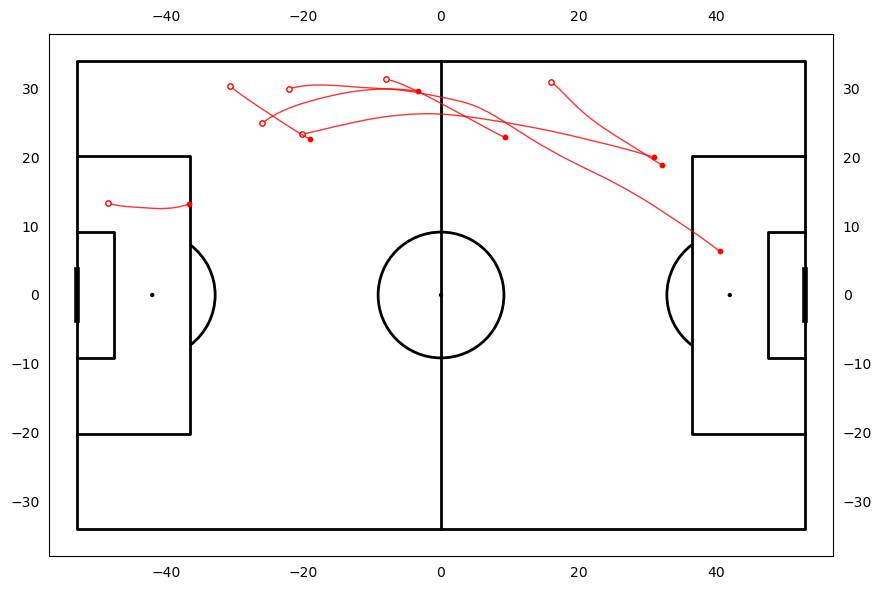

In [23]:
#Ruan
starting_RB_overlaps = find_overlapping_runs(starting_RB)
print(starting_RB_overlaps)
plot_runs(starting_RB, starting_RB_overlaps)

[(9094, 9207), (11725, 11769), (42578, 42598), (51519, 51599), (109183, 109381)]


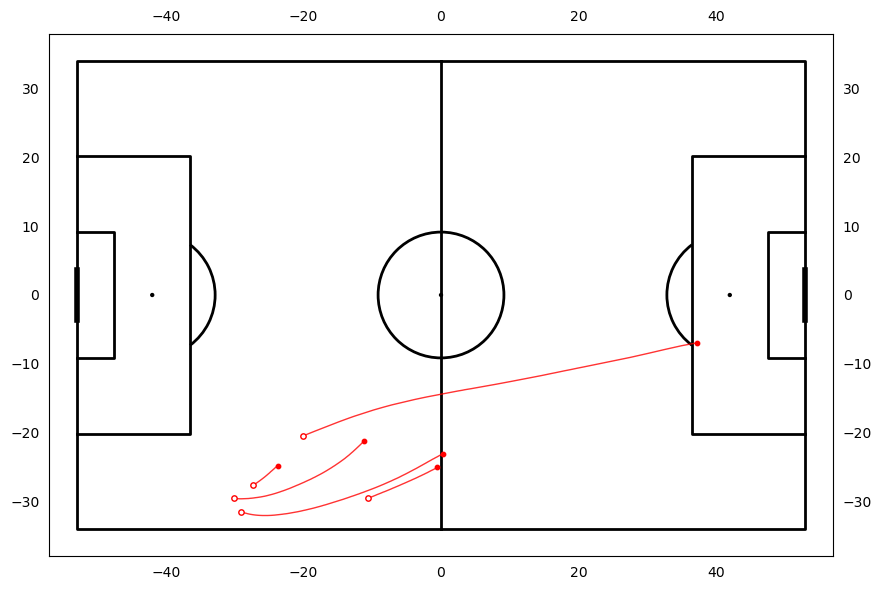

In [24]:
# Joao
starting_LB_overlaps = find_overlapping_runs(starting_LB)
print(starting_LB_overlaps)
plot_runs(starting_LB, starting_LB_overlaps)

[(117180, 117310), (141334, 141365)]


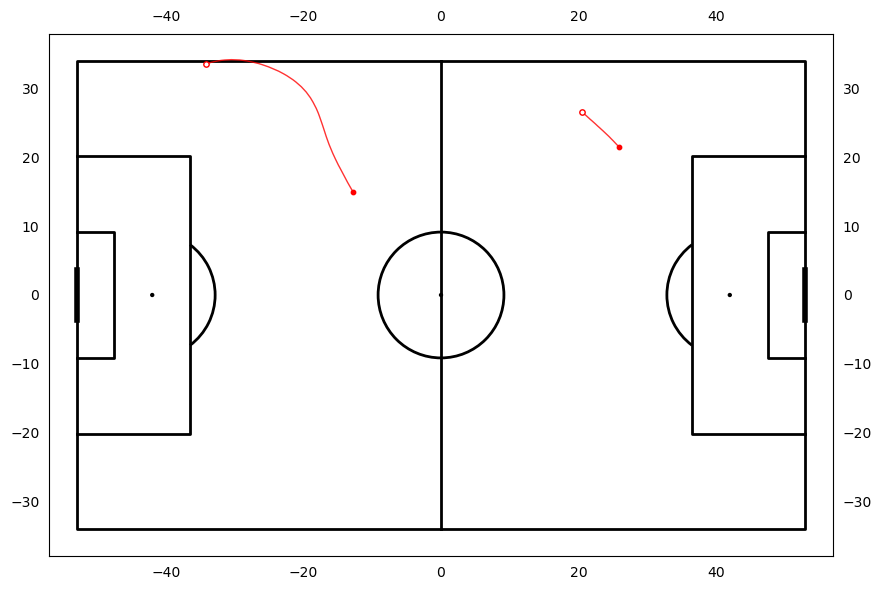

In [25]:
# Smith
sub_RB_overlaps = find_overlapping_runs(sub_RB)
print(sub_RB_overlaps)
plot_runs(sub_RB, sub_RB_overlaps)

 # Rank Each Run

In [26]:
sub_RB_overlaps

[(117180, 117310), (141334, 141365)]

In [27]:
sub_RB_overlaps[0][0]

117180

In [30]:
#first get frames
#filter out team_df's to fit frames
#initialise players
#find fullback's position
def iterateArrays(array, player, home_team, away_team):
    results = []
    params = default_model_params()
    epv = load_EPV_grid()
    
    for i in range(len(array)):
        
        #first get frames
        start_frame = array[i][0]
        end_frame = array[i][1]
        
        #filter out team_df's to fit frames
        start_home = home_team[home_team['frame_idx'] == start_frame]
        start_away = away_team[away_team['frame_idx'] == start_frame]
        end_home = home_team[home_team['frame_idx'] == end_frame]
        end_away = away_team[away_team['frame_idx'] == end_frame]
        
        #initialise players
        start_attacking_players = initialise_players(start_home,'Home',params,1)
        start_defending_players = initialise_players(start_away ,'Away',params,1)
        end_attacking_players = initialise_players(end_home,'Home',params,1)
        end_defending_players = initialise_players(end_away,'Away',params,1)
        
        #find fullback's position
        player_pos_start = start_home[start_home['player_id'] == player][['x','y']].to_numpy()
        player_pos_end = end_home[end_home['player_id'] == player][['x','y']].to_numpy()
        
        
        start_epv= get_EPV_at_location(player_pos_start, epv, -1)
        end_epv = get_EPV_at_location(player_pos_end, epv, -1)
        
        
        patt_start = calculate_pitch_control_at_target(player_pos_start, start_attacking_players, start_defending_players, player_pos_start, params)[0]
        patt_end = calculate_pitch_control_at_target(player_pos_end, end_attacking_players, end_defending_players, player_pos_end, params)[0]
        
        value = ((patt_end*end_epv) - (patt_start*end_epv) )* 1000
        results.append((value))
    return results

In [111]:
sub_rb_values = iterateArrays(sub_RB_overlaps, sub_rb_id, orlando_df, chicago_df)
lb_values = iterateArrays(starting_LB_overlaps, starting_lb_id, orlando_df, chicago_df)
rb_values = iterateArrays(starting_RB_overlaps, starting_rb_id, orlando_df, chicago_df)

In [112]:
data1 = {
    'player': ["Ruan"] * len(starting_RB_overlaps),
    'player_id': [starting_rb_id] * len(starting_RB_overlaps),
    'start_frame': [item[0] for item in starting_RB_overlaps],
    'end_frame': [item[1] for item in starting_RB_overlaps],
    'run_value': [item for item in rb_values]
}
df1 = pd.DataFrame(data1)
data2 = {
    'player': ["Joao"] * len(starting_LB_overlaps),
    'player_id': [starting_lb_id] * len(starting_LB_overlaps),
    'start_frame': [item[0] for item in starting_LB_overlaps],
    'end_frame': [item[1] for item in starting_LB_overlaps],
    'run_value': [item for item in lb_values]
}
df2 = pd.DataFrame(data2)
data3 = {
    'player': ["Smith"] * len(sub_RB_overlaps),
    'player_id': [sub_rb_id] * len(sub_RB_overlaps),
    'start_frame': [item[0] for item in sub_RB_overlaps],
    'end_frame': [item[1] for item in sub_RB_overlaps],
    'run_value': [item for item in sub_rb_values]
}
df3 = pd.DataFrame(data3)

final_list = pd.concat([df1, df2,df3], ignore_index=True)
final_list

,player,player_id,start_frame,end_frame,run_value
0,Ruan,246099,10254,10327,-2.109998
1,Ruan,246099,45657,45702,-11.300216
2,Ruan,246099,49290,49460,4.164571
3,Ruan,246099,57220,57272,5.570368
4,Ruan,246099,77391,77464,8.702979
5,Ruan,246099,81451,81523,0.321059
6,Ruan,246099,110662,110931,12.255284
7,Joao,443002,9094,9207,13.432819
8,Joao,443002,11725,11769,-0.572094
9,Joao,443002,42578,42598,-1.372026


In [114]:
start_list = []
end_list = []
for i in range(len(final_list)):
    temp_start_frame = final_list['start_frame'][i]
    temp_end_frame = final_list['end_frame'][i]
    temp_start = orlando_df[orlando_df['frame_idx'] == temp_start_frame].game_clock.iloc[0]
    temp_end = orlando_df[orlando_df['frame_idx'] == temp_end_frame].game_clock.iloc[0]
    if(temp_start_frame >= 68699):
        temp_start = temp_start + 2700
        temp_end = temp_end + 2700
    start_list.append(temp_start/60)
    end_list.append(temp_end/60)
    
final_list['start_clock'] = start_list
final_list['end_clock'] = end_list

In [115]:
final_list.sort_values('run_value', ascending = False)

,player,player_id,start_frame,end_frame,run_value,start_clock,end_clock
7,Joao,443002,9094,9207,13.432819,6.062667,6.138000
6,Ruan,246099,110662,110931,12.255284,72.975333,73.154667
11,Joao,443002,109183,109381,11.199187,71.989333,72.121333
4,Ruan,246099,77391,77464,8.702979,50.794667,50.843333
3,Ruan,246099,57220,57272,5.570368,38.146667,38.181333
2,Ruan,246099,49290,49460,4.164571,32.860000,32.973333
5,Ruan,246099,81451,81523,0.321059,53.501333,53.549333
13,Smith,227733,141334,141365,0.274576,93.423333,93.444000
8,Joao,443002,11725,11769,-0.572094,7.816667,7.846000
9,Joao,443002,42578,42598,-1.372026,28.385333,28.398667


# Plot Functions

In [116]:
def plot_frame(frame, home_team, away_team):
    print("Plotting frame:", frame)
    pitch = mpl.Pitch(pitch_type='secondspectrum', pitch_length=106, pitch_width=68, line_color = 'black', 
                  axis = True, label = True)
    fig, ax = pitch.draw(figsize=(9,6))
    
    home_df = home_team[home_team['frame_idx'] == frame]
    away_df = away_team[away_team['frame_idx'] == frame]
    
    # Plot players
    ax.scatter(home_df['x'],home_df['y'], color= 'blue')
    ax.scatter(away_df['x'],away_df['y'], color= 'red')
    
     # Plot player velocities
    ax.quiver(home_df['x'], home_df['y'], home_df['vx'], home_df['vy'], color='blue', scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=0.7)
    ax.quiver(away_df['x'], away_df['y'], away_df['vx'], away_df['vy'], color='red', scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=0.7)
    # Plot ball
    ax.scatter(home_df['ball_x'].iloc[0], home_df['ball_y'].iloc[0], color = 'green', s = 60)
    
     # Add player numbers as text
    for index, player in home_df.iterrows():
        ax.text(player['x']+0.5, player['y']+0.5, str(player['player_number']), color='blue', fontsize=8, ha='center', va='bottom')
    
    for index, player in away_df.iterrows():
        ax.text(player['x']+0.5, player['y']+0.5, str(player['player_number']), color='red', fontsize=8, ha='center', va='bottom')

In [117]:
def plot_pitch_control(frame, home_team, away_team, PPCF, field_dimen = (106.0,68)):
    print("Plotting frame:", frame)
    pitch = mpl.Pitch(pitch_type='secondspectrum', pitch_length=106, pitch_width=68, line_color = 'black', 
                  axis = True, label = True)
    fig, ax = pitch.draw(figsize=(9,6))
    
    home_df = home_team[home_team['frame_idx'] == frame]
    away_df = away_team[away_team['frame_idx'] == frame]
    
    # Plot players
    ax.scatter(home_df['x'],home_df['y'], color= 'blue')
    ax.scatter(away_df['x'],away_df['y'], color= 'red')
    
     # Plot player velocities
    ax.quiver(home_df['x'], home_df['y'], home_df['vx'], home_df['vy'], color='blue', scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=0.7)
    ax.quiver(away_df['x'], away_df['y'], away_df['vx'], away_df['vy'], color='red', scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=0.7)
    # Plot ball
    ax.scatter(home_df['ball_x'].iloc[0], home_df['ball_y'].iloc[0], color = 'green', s = 60)
    
     # Add player numbers as text
    for index, player in home_df.iterrows():
        ax.text(player['x']+0.5, player['y']+0.5, str(player['player_number']), color='blue', fontsize=8, ha='center', va='bottom')
    
    for index, player in away_df.iterrows():
        ax.text(player['x']+0.5, player['y']+0.5, str(player['player_number']), color='red', fontsize=8, ha='center', va='bottom')
    

    
    # Add Pitch Control
    ax.imshow(np.flipud(PPCF), extent=(-field_dimen[0]/2., field_dimen[0]/2., -field_dimen[1]/2., field_dimen[1]/2.),interpolation='spline36',vmin=0.0,vmax=1.0,cmap='bwr_r',alpha=0.5)


Plotting frame: 9207


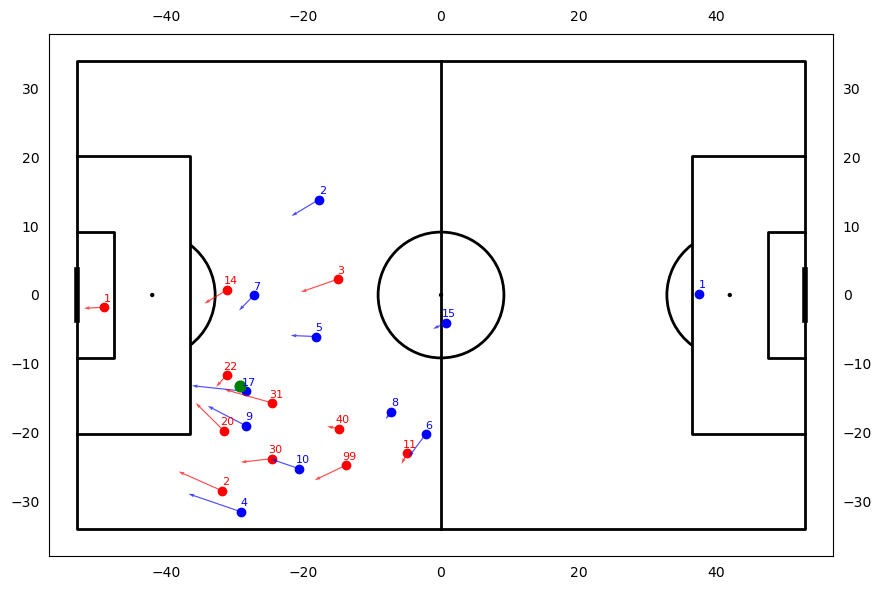

In [118]:
start_frame = 9094
end_frame = 9207
plot_frame(end_frame, orlando_df, chicago_df)

Plotting frame: 9094


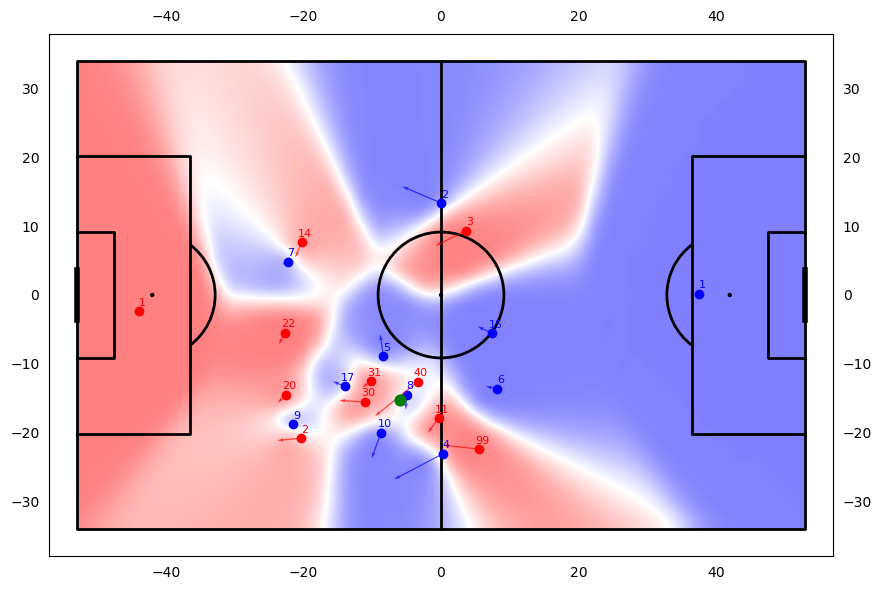

In [122]:
params = default_model_params()
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(start_frame, orlando_df, chicago_df, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitch_control(start_frame, orlando_df, chicago_df, PPCF, field_dimen = (106.0,68))

Plotting frame: 9207


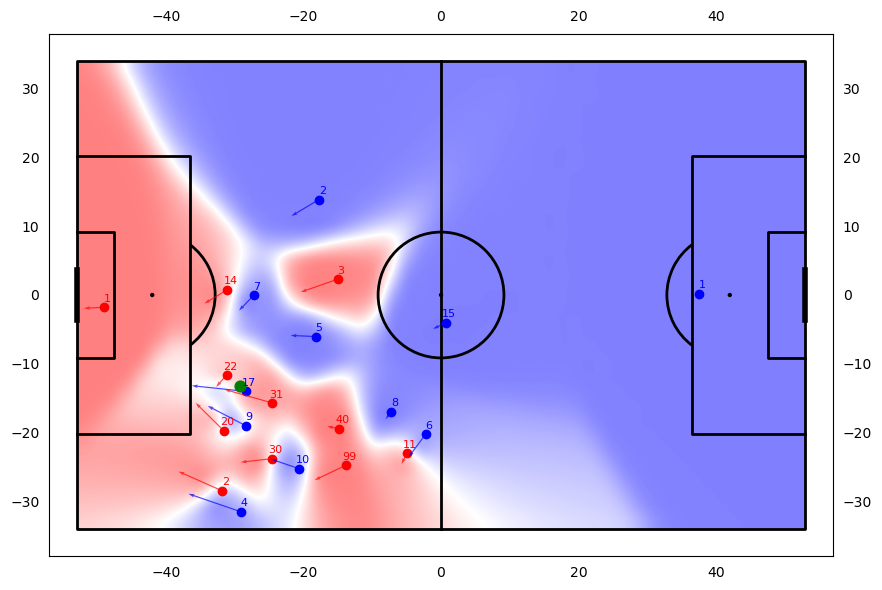

In [123]:
PPCF,xgrid,ygrid = generate_pitch_control_for_frame(end_frame, orlando_df, chicago_df, params, field_dimen = (106.,68.,), n_grid_cells_x = 50)
plot_pitch_control(end_frame, orlando_df, chicago_df, PPCF, field_dimen = (106.0,68))